In [60]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime
import statsmodels as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [61]:
df_sp500 = pd.read_csv('SP500.csv')
df_sp500.head(10)

,DATE,SP500
0,2010-06-28,1074.57
1,2010-06-29,1041.24
2,2010-06-30,1030.71
3,2010-07-01,1027.37
4,2010-07-02,1022.58
5,2010-07-05,.
6,2010-07-06,1028.06
7,2010-07-07,1060.27
8,2010-07-08,1070.25
9,2010-07-09,1077.96


In [62]:
df_sp500.shape

(2610, 2)

In [63]:
df_sp500.dtypes

,0
DATE,object
SP500,object


In [64]:
df_sp500['SP500'] = pd.to_numeric(df_sp500['SP500'], errors='coerce')
df_sp500['DATE'] = pd.to_datetime(df_sp500['DATE']).dt.date

In [65]:
df_sp500.dropna(inplace=True)

In [66]:
df_sp500.set_index('DATE', inplace=True)

In [67]:
df_sample = df_sp500[(df_sp500.index > datetime.date(2015,1,1))
# & (df_sp500['DATE']<datetime.date(2016,3,1))]
]

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'S&P 500')]

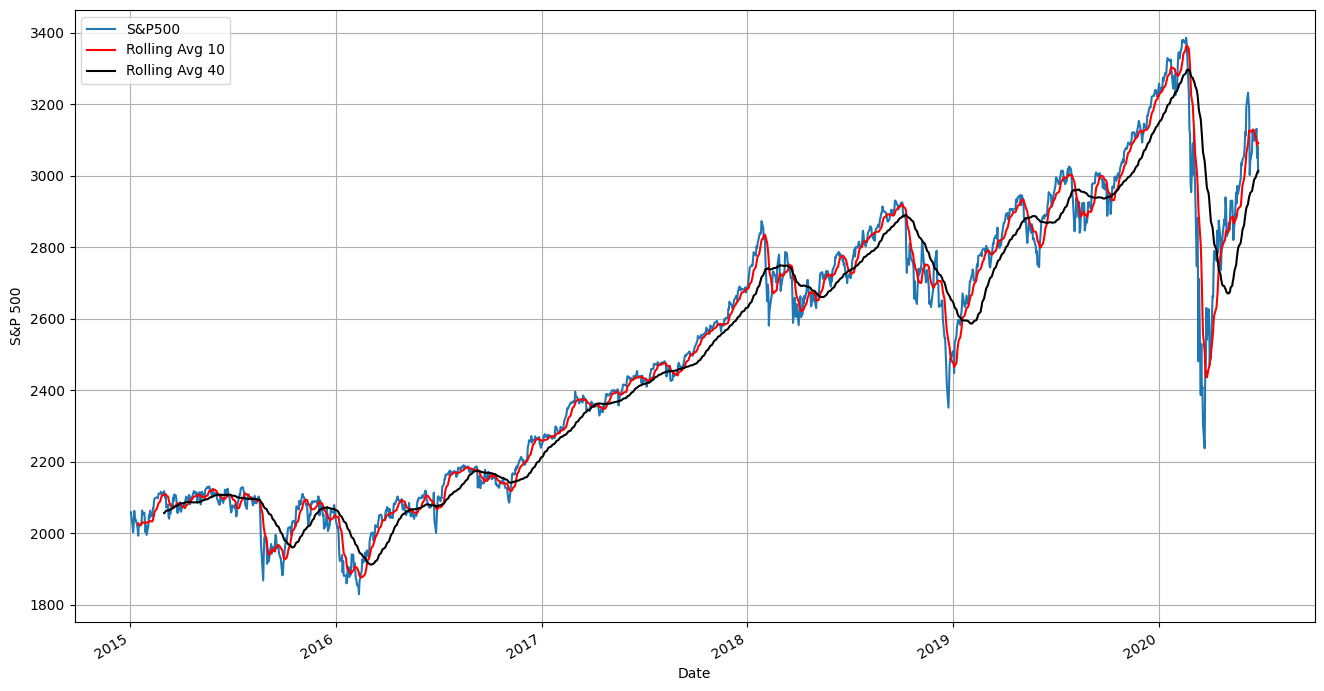

In [68]:
roll_avg_10 = df_sample.SP500.rolling(window=10).mean()
roll_avg_40 = df_sample.SP500.rolling(window=40).mean()

fig, ax = plt.subplots(figsize=(16, 9))
fig.autofmt_xdate()
ax.plot(df_sample.SP500, label='S&P500', color='tab:blue')
ax.plot(roll_avg_10, label='Rolling Avg 10', color='r')
ax.plot(roll_avg_40, label='Rolling Avg 40', color='k')
ax.legend()
ax.grid()
ax.set(xlabel='Date',ylabel='S&P 500')


In PACF plot, the partial autocorrelation spikes for the first 1-2 lags, and then drops off rapidly to near-zero correlations for higher lags

In ACF plot, the autocorrelations stay high and do not decay quickly, as shown by the tall bars extending across many lags. This behavior suggests that each value in the time series is highly correlated with many of its past values, which is a characteristic of non-stationary series."

AUGMENTED DICKEY FULLER TEST

In [69]:
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

check_stationarity(df_sample.SP500)

The test statistic: -1.508554
p-value: 0.529276
Critical Values:
1%: -3.435
5%: -2.864
10%: -2.568


The value of test statistics is more than 5% critical value and p-value is also
more than 0.05 so we can not accept Alternate Hypothesis at this significance level. The time series is non stationary.

In [70]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

df_diff =  difference(df_sample.SP500, 1)

In [71]:
df_diff.head()

,0
0,-37.62
1,-17.97
2,23.29
3,36.24
4,-17.33


<Axes: >

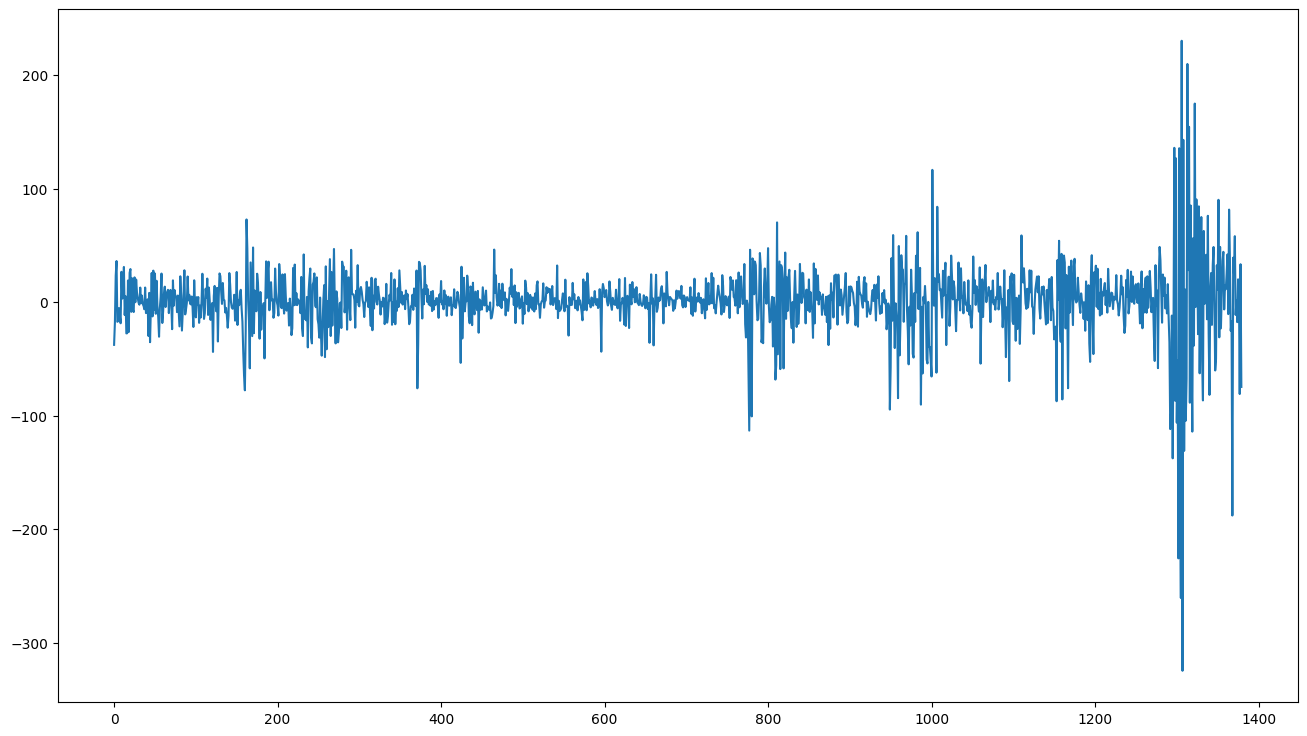

In [72]:
df_diff.plot(figsize=(16, 9))

In [73]:
df_sample = df_sample.assign(y_log=np.log(df_sample.SP500))
df_sample.head()

,SP500,y_log
DATE,,
2015-01-02,2058.20,7.629587
2015-01-05,2020.58,7.611140
2015-01-06,2002.61,7.602207
2015-01-07,2025.90,7.613769
2015-01-08,2062.14,7.631500


# ARIMA

In [74]:
p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 6)

pdq = list(itertools.product(p, d, q))

In [75]:
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

aic_scores = {}

for param in pdq:
    try:
        model = ARIMA(df_sample.y_log, order=param)
        results = model.fit()
        aic_scores[param] = results.aic
        print(f'ARIMA{param} - AIC: {results.aic}')
    except Exception as e:
        print(f"Error with ARIMA{param}: {e}")
        continue

if aic_scores:
    max_aic_param = max(aic_scores, key=lambda k: abs(aic_scores[k]))
    max_aic_score = aic_scores[max_aic_param]
    print(f'\nOrder with Maximum Absolute AIC: {max_aic_param} - AIC: {max_aic_score}')
else:
    print("No valid AIC scores were computed.")


ARIMA(0, 0, 0) - AIC: -1251.4728456951393
ARIMA(0, 0, 1) - AIC: -3051.2135586201293
ARIMA(0, 0, 2) - AIC: -4289.552053162222
ARIMA(0, 0, 3) - AIC: -5253.714540758876
ARIMA(0, 0, 4) - AIC: -5805.521306666206
ARIMA(0, 0, 5) - AIC: -6404.21512771151
ARIMA(0, 1, 0) - AIC: -8305.78866392331
ARIMA(0, 1, 1) - AIC: -8354.815346110152
ARIMA(0, 1, 2) - AIC: -8381.500883597568
ARIMA(0, 1, 3) - AIC: -8381.717777160444
ARIMA(0, 1, 4) - AIC: -8384.636039333398
ARIMA(0, 1, 5) - AIC: -8386.490851895576
ARIMA(0, 2, 0) - AIC: -7079.825819263075
ARIMA(0, 2, 1) - AIC: -8238.457100460257
ARIMA(0, 2, 2) - AIC: -8339.986815796325
ARIMA(0, 2, 3) - AIC: -8365.761926303998
ARIMA(0, 2, 4) - AIC: -8365.844009972861
ARIMA(0, 2, 5) - AIC: -8331.423695504578
ARIMA(1, 0, 0) - AIC: -8304.262220904166
ARIMA(1, 0, 1) - AIC: -8352.732295928708
ARIMA(1, 0, 2) - AIC: -8379.780105343958
ARIMA(1, 0, 3) - AIC: -8379.69435586217
ARIMA(1, 0, 4) - AIC: -8382.422636959978
ARIMA(1, 0, 5) - AIC: -8384.418163722392
ARIMA(1, 1, 0) - 

In [22]:
best_order = (10,1,0)
model = ARIMA(df_sample.y_log, order=best_order)
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  y_log   No. Observations:                 1381
Model:                ARIMA(10, 1, 0)   Log Likelihood                4254.115
Date:                Tue, 17 Dec 2024   AIC                          -8486.231
Time:                        11:20:50   BIC                          -8428.702
Sample:                             0   HQIC                         -8464.710
                               - 1381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1231      0.014     -9.015      0.000      -0.150      -0.096
ar.L2          0.0679      0.013      5.119      0.000       0.042       0.094
ar.L3          0.0538      0.014      3.880      0.0

In [23]:
df_sample.shape

(1381, 2)

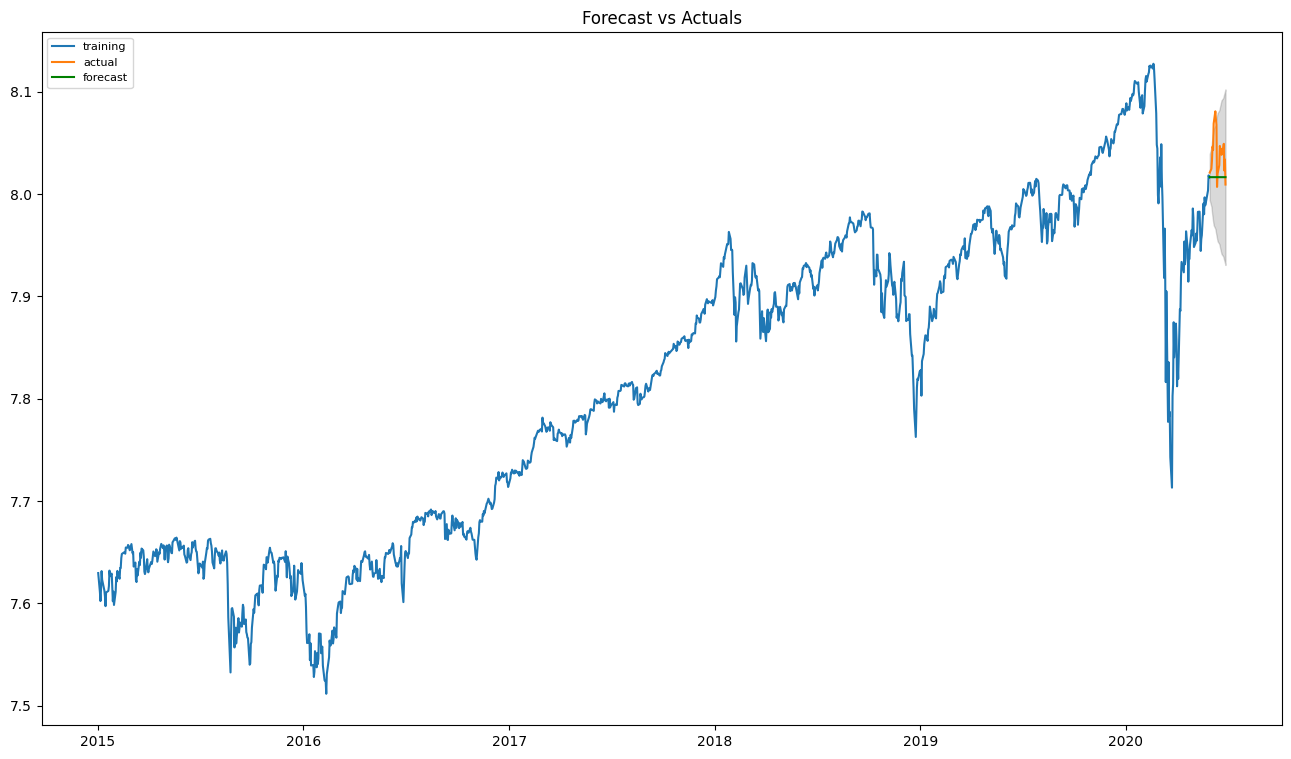

In [76]:
TRAIN_END_INDEX = 1360

train = df_sample.y_log[:TRAIN_END_INDEX]
test = df_sample.y_log[TRAIN_END_INDEX:]

model = ARIMA(train, order=best_order)
fitted = model.fit()

forecast_result = fitted.get_forecast(steps=len(test), alpha=0.05)
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

fc_series = pd.Series(fc.values, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index)

plt.figure(figsize=(16, 9))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(test.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [77]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('ARIMA model mse :', mean_squared_error(np.exp(test), np.exp(fc_series)))
print('ARIMA model mae :', mean_absolute_error(np.exp(test), np.exp(fc_series)))
print('ARIMA model mape :', mean_absolute_percentage_error(np.exp(test), np.exp(fc_series)))

ARIMA model mse : 9181.1675048473
ARIMA model mae : 78.38246104113006
ARIMA model mape : 2.492042838679645


#SARIMA

In [52]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [55]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df_sample.y_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:9592.66769121692
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7684.807638467729
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-5148.817955840603
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-5092.821269253865
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-5164.531728639007
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-5158.009874422216
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-5097.319373717808
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-5103.687850967865
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7684.616298678317
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5793.680125711696
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-6213.711919460147
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-6178.220523794178
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-6229.826646315692
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-6252.456208176128
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-6176.691802716492
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-6239.36413801804
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-8301.162070444681
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-8232.03784161632

In [57]:
model_sarima = SARIMAX(df_sample.y_log,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.61e-05   2.77e+04      0.000       1.000       1.000
ma.L1         -0.1952      0.010    -19.248      0.000      -0.215      -0.175
sigma2         0.0001   1.73e-06     78.980      0.000       0.000       0.000


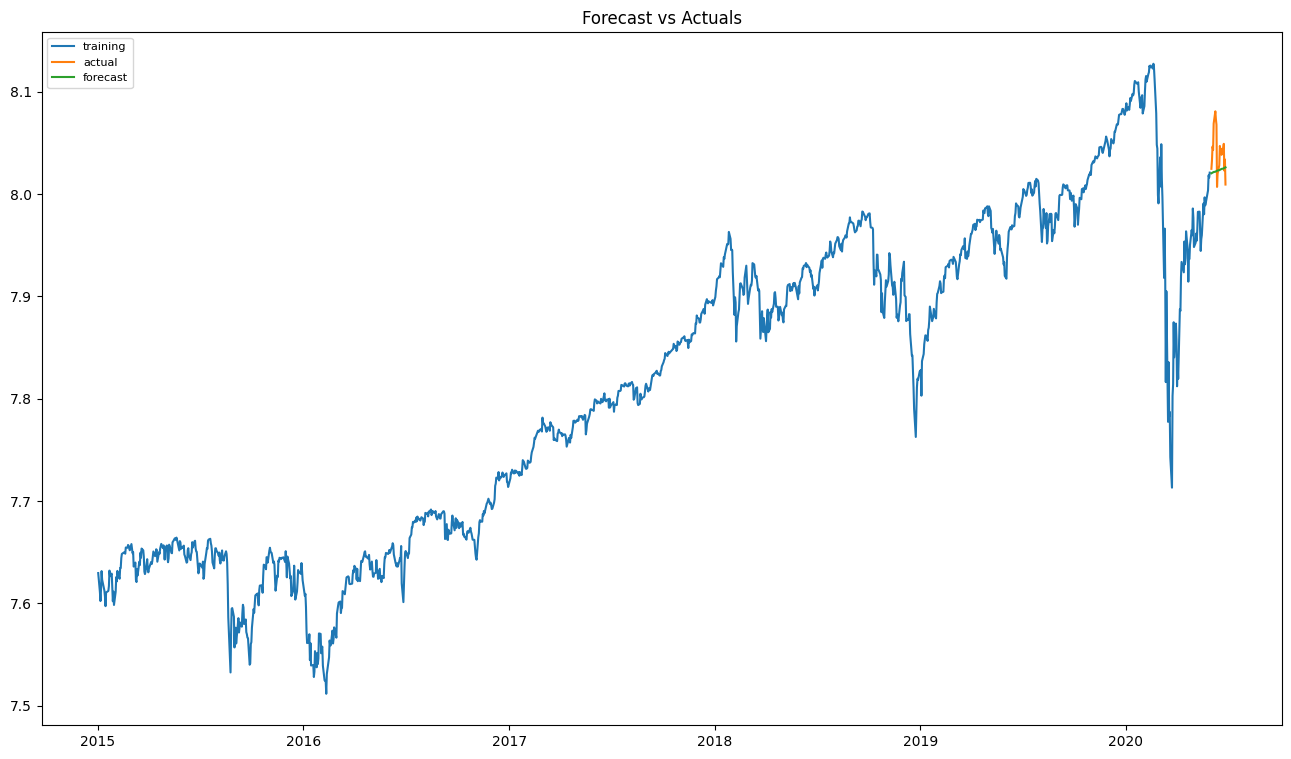

In [58]:
model = SARIMAX(train,
                order=(1, 0, 1),
                seasonal_order=(0, 0, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

fitted = model.fit(disp=-1)

fc = fitted.forecast(20)

fc_series = pd.Series(fc.values, index=test.index)

plt.figure(figsize=(16, 9))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)


In [59]:
print('SARIMAX model MSE :', mean_squared_error(np.exp(test), np.exp(fc_series)))
print('SARIMAX model MAE :', mean_absolute_error(np.exp(test), np.exp(fc_series)))
print('SARIMAX model MAPE :', mean_absolute_percentage_error(np.exp(test), np.exp(fc_series)))


SARIMAX model MSE : 7160.399849765299
SARIMAX model MAE : 67.83487405471803
SARIMAX model MAPE : 2.1557077179276494
